# Sediment resuspension --- regions of importance

In [1]:
import os
os.environ['PROJ_LIB'] = '/home/brogalla/anaconda3/share/proj'

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
import cmocean
import pandas as pd
import pickle
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

%matplotlib notebook

In [4]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

#### Load model bathymetry

In [5]:
land_color = "#8b7765"

# load bathymetry file:
mesh     = nc.Dataset('/ocean/brogalla/GEOTRACES/analysis-birgit/notebooks/ANHA12/ANHA12_mesh1.nc')
mesh_lon = np.array(mesh.variables['nav_lon'])[1480:2180, 160:800]
mesh_lat = np.array(mesh.variables['nav_lat'])[1480:2180, 160:800]
mesh_bathy = np.array(mesh.variables['hdept'][0])
tmask      = np.array(mesh.variables['tmask'][0,:,:,:])
Z_masked   = np.ma.masked_where((tmask > 0.1), tmask) 
e3t0       = np.array(mesh.variables['e3t_0'])
nav_lev    = np.array(mesh.variables['nav_lev'])

In [6]:
c = nc.Dataset('/data/brogalla/run_storage/Mn-set1-201910/reference/ANHA12_EXH006_2002_monthly.nc', 'r')

# Load structure from sample dataset:
lat_model = c.variables['nav_lat']
lon_model = c.variables['nav_lon']
depths_model = c.variables['deptht']
lat_model = np.array(lat_model)
lon_model = np.array(lon_model)
depths_model = np.array(depths_model)

In [7]:
bathy      = mesh_bathy[1480:2180,160:800]
flux       = 8.0e-9  # g/m2/s

In [8]:
importance = np.zeros_like(bathy)
sediment   = np.zeros_like(bathy)

for i in range(0,700):
    for j in range(0, 640):
        importance[i,j] = np.exp(-0.5*(bathy[i,j]-300)**2/(200**2))
        for z in range(0,50):
            if (bathy[i,j] <= nav_lev[z] and bathy[i,j] >= nav_lev[z-1]):
                zbottom = e3t0[0,z,1480+i,160+j]                
                sediment[i,j] = importance[i,j] / zbottom

In [9]:
c           = nc.Dataset('/ocean/brogalla/GEOTRACES/data/erosion_rate-20200105.nc','r')
resus_class = np.array(c.variables['er_rate'])[1480:2180, 160:800]

Create colormap:

In [12]:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(164/N, 1, N)
vals_cont[:, 1] = np.linspace(116/N, 1, N)
vals_cont[:, 2] = np.linspace(84/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

<IPython.core.display.Javascript object>


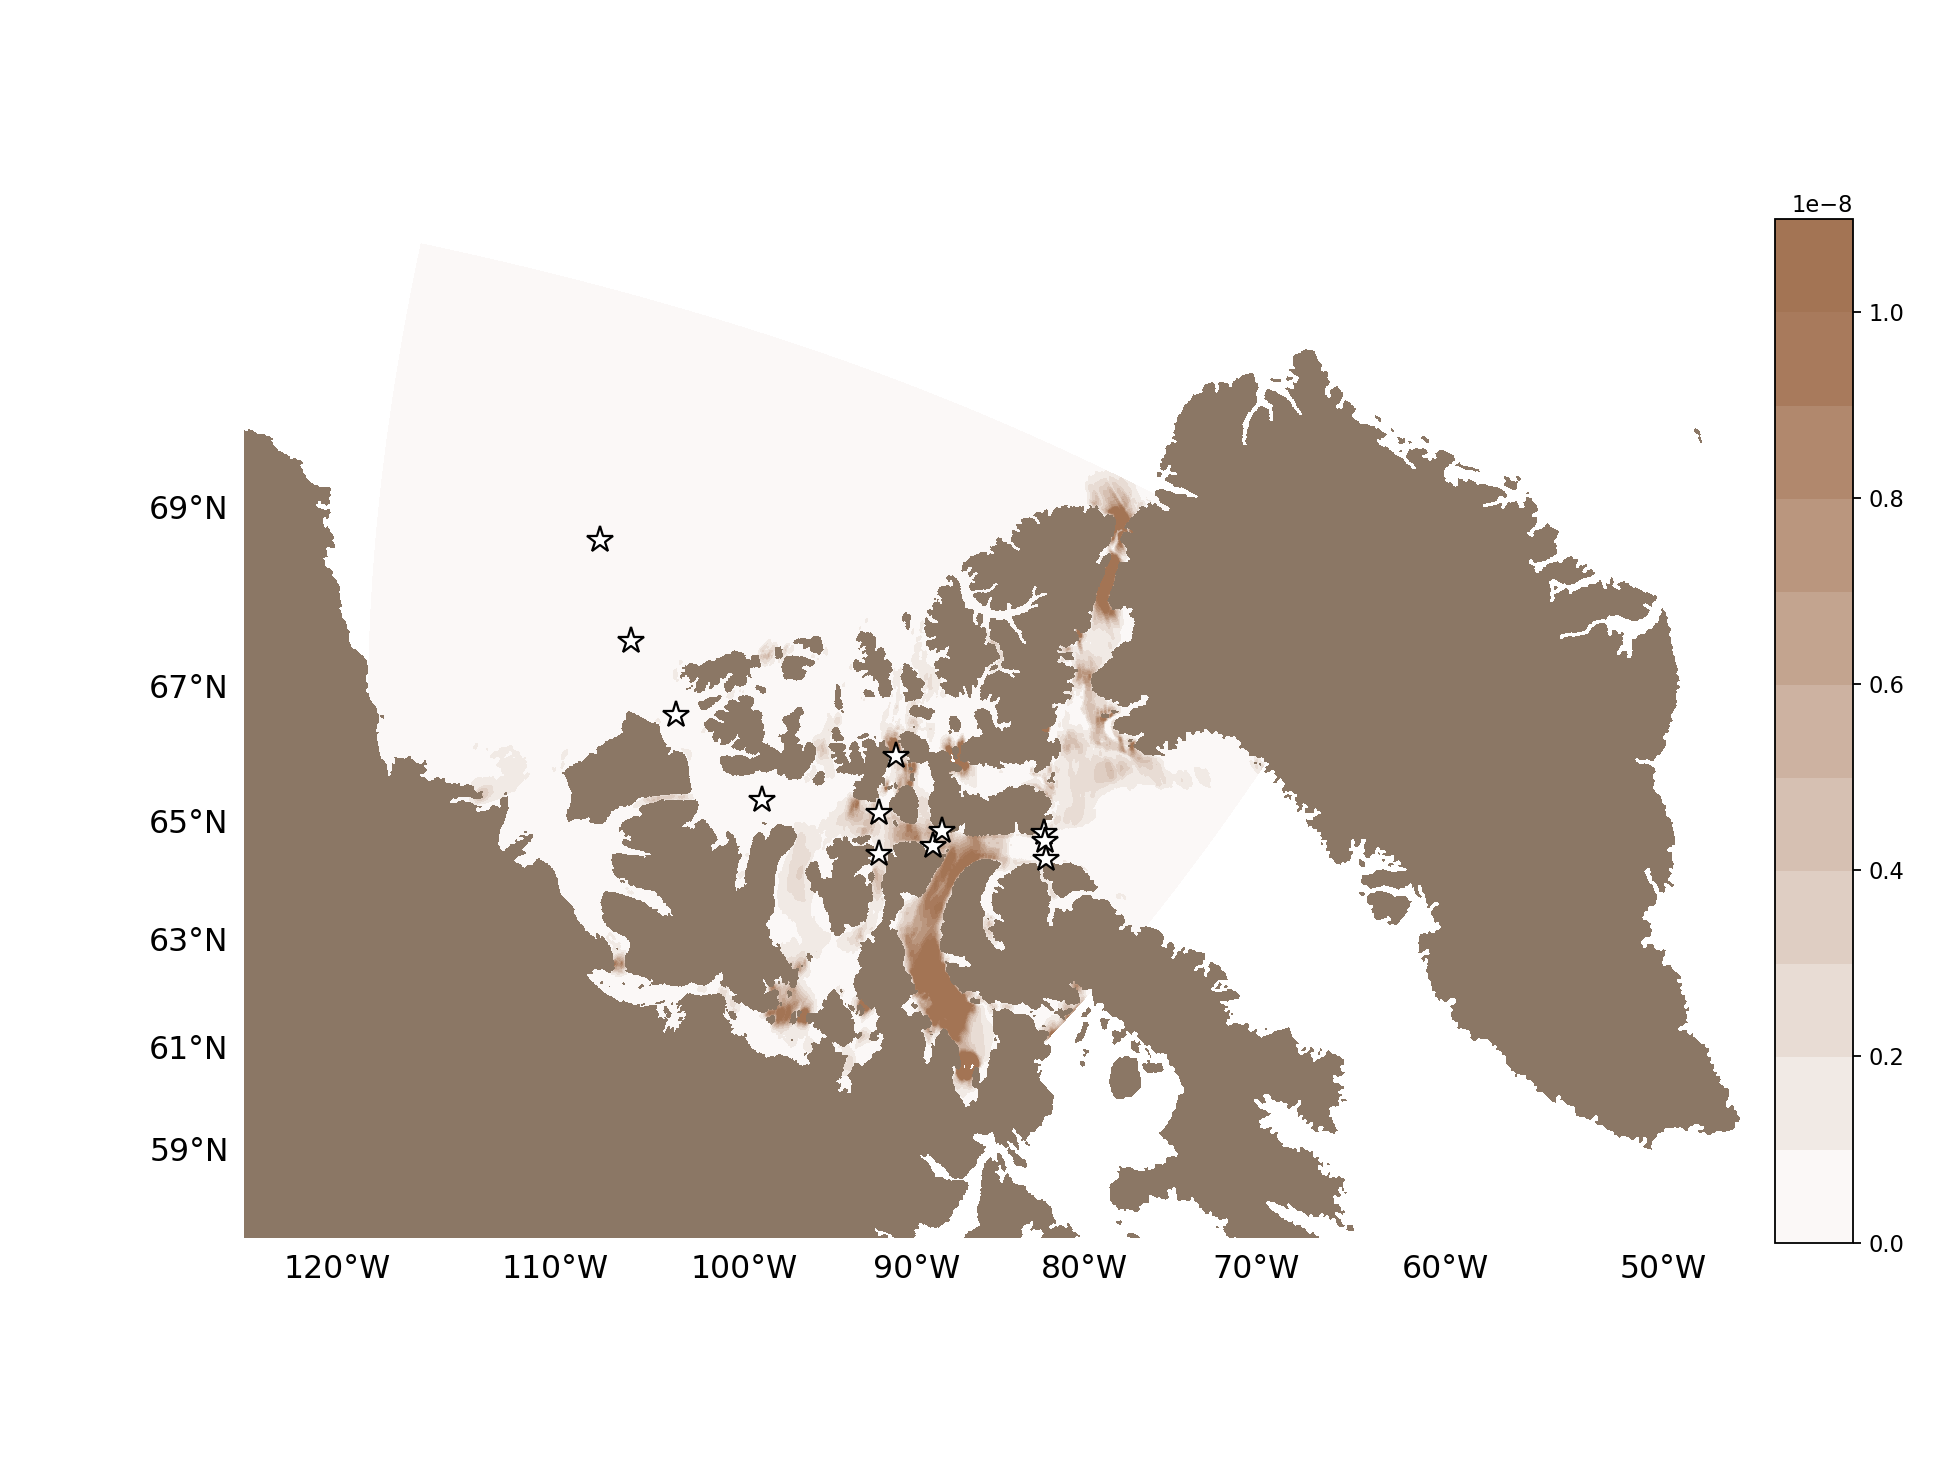

In [18]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/mn-reference.pickle','rb'))
#-----------------------------------------------------------------------------

x, y = proj1(mesh_lon, mesh_lat)

cbar = proj1.contourf(x, y, importance*resus_class, \
                      levels=[0,1e-9,2e-9,3e-9,4e-9,5e-9,6e-9,7e-9,8e-9,9e-9,1e-8,5e-8], \
                      vmin=0, vmax=1.0e-8, cmap=cont_cmap)

x_stn, y_stn = proj1([lon_model[104,370], lon_model[100,365], lon_model[91,353],  lon_model[175,311], \
                      lon_model[175,326], lon_model[233,313], lon_model[214,281], lon_model[352,281], \
                      lon_model[242,364], lon_model[458,332], lon_model[508,384], lon_model[547,457]], \
                     [lat_model[104,370], lat_model[100,365], lat_model[91,353],  lat_model[175,311], \
                      lat_model[175,326], lat_model[233,313], lat_model[214,281], lat_model[352,281], \
                      lat_model[242,364], lat_model[458,332], lat_model[508,384], lat_model[547,457]])

proj1.plot(x_stn, y_stn, '*w', markersize=12, markeredgecolor='k')

cbar_ax = fig.add_axes([0.91, 0.15, 0.04, 0.7])
c_bar = fig.colorbar(cbar, cax=cbar_ax, ticks=[0, 2e-9, 4e-9, 6e-9, 8e-9, 1e-8])

fig.savefig('/ocean/brogalla/GEOTRACES/figures/fig-erosion_rate.png', bbox_inches='tight', dpi=300)